In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
#minha funcao para mostrar as imagens
def imshow(im,big=False):
    if big:
        plt.figure(figsize=(20,20))
    else:
        plt.figure()
    if len(im.shape)<3:
        plt.imshow(im, cmap='gray')#As cores ficam zoadas no Jupyter se deixar sem esse parâmetro
    else:
        plt.imshow(im[:,:,::-1]) 
    plt.axis('off')
    plt.show()

***
# Contornos

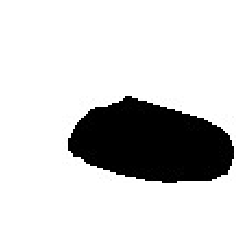

In [3]:
im = cv2.imread('imgs/im.jpg')
im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
imshow(im_gray)

cv2.findContours
### mode:
RETR_EXTERNAL 	
retrieves only the extreme outer contours. It sets hierarchy[i][2]=hierarchy[i][3]=-1 for all the contours.

RETR_LIST 	
retrieves all of the contours without establishing any hierarchical relationships.

RETR_CCOMP 	
retrieves all of the contours and organizes them into a two-level hierarchy. At the top level, there are external boundaries of the components. At the second level, there are boundaries of the holes. If there is another contour inside a hole of a connected component, it is still put at the top level.

RETR_TREE 	
retrieves all of the contours and reconstructs a full hierarchy of nested contours.

RETR_FLOODFILL 	

### method:
CHAIN_APPROX_NONE 	
stores absolutely all the contour points. That is, any 2 subsequent points (x1,y1) and (x2,y2) of the contour will be either horizontal, vertical or diagonal neighbors, that is, max(abs(x1-x2),abs(y2-y1))==1.

CHAIN_APPROX_SIMPLE 	
compresses horizontal, vertical, and diagonal segments and leaves only their end points. For example, an up-right rectangular contour is encoded with 4 points.

CHAIN_APPROX_TC89_L1 	
applies one of the flavors of the Teh-Chin chain approximation algorithm [168]

CHAIN_APPROX_TC89_KCOS 	
applies one of the flavors of the Teh-Chin chain approximation algorithm [168]

In [4]:
ret,thresh = cv2.threshold(im_gray,127,255,0)
con,h = cv2.findContours(thresh,mode=cv2.RETR_TREE,method = cv2.CHAIN_APPROX_SIMPLE)
len(con)

2

### Isso aqui não funcionou direito - tentativa de suavizar os contornos

In [ ]:
from scipy.interpolate import splprep, splev

In [ ]:
def suaviza_contorno (contorno):
    x,y = contorno.T
    
    # Convert from numpy arrays to normal arrays
    x = x.tolist()[0]
    y = y.tolist()[0]
    
    # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.splprep.html
    tck, u = splprep([x,y], u=None, s=1.0, per=1)
    
    # https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.linspace.html
    u_new = np.linspace(u.min(), u.max(), 1000)
    
    # https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.splev.html
    x_new, y_new = splev(u_new, tck, der=0)
    
    # Convert it back to numpy format for opencv to be able to display it
    res_array = [[[int(i[0]), int(i[1])]] for i in zip(x_new,y_new)]
    return np.asarray(res_array, dtype=np.int32)

In [ ]:
con_suavizado = []
con_suavizado.append(suaviza_contorno(con[0]))
con_suavizado.append(suaviza_contorno(con[1]))

### Testando o método de interpolação splprep do scipy

In [25]:
from scipy.interpolate import splprep, splev

In [26]:
phi = np.linspace(0, 2.*np.pi, 40)
r = 0.5 + np.cos(phi)
x, y = r * np.cos(phi), r * np.sin(phi)

In [27]:
tck, u = splprep([x, y], s=0, per=1)
u_new = np.linspace(u.min(), u.max(), 1000)
new_points = splev(u_new, tck)

/usr/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][40]=x[1][0]
  (i, m, i)))


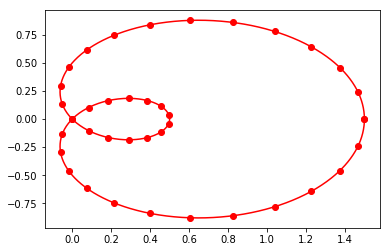

In [28]:
fig, ax = plt.subplots()
ax.plot(x, y, 'ro')
ax.plot(new_points[0], new_points[1], 'r-')
plt.show()

# Aproximando por poligonos
https://docs.opencv.org/2.4/modules/imgproc/doc/structural_analysis_and_shape_descriptors.html

In [5]:
def pinta_poligonos(im_contornar,poligonos,lineThickness=1):
    im_contorno = im_contornar.copy()
    cv2.polylines(im_contorno, [poligonos], True, (0, 0, 255), lineThickness)
    return im_contorno

In [39]:
#transforma o contorno 1 em poligonos
poligonos = cv2.approxPolyDP(con[1],epsilon=0.5,closed = True)
len(poligonos)

51

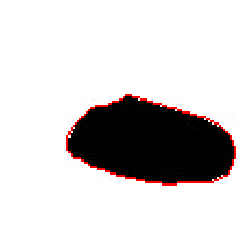

In [40]:
imshow(pinta_poligonos(im,poligonos,1))

### Desenhando contornos em imagem 4 vezes maior

In [41]:
im_4x = np.ones((400,400,3)).astype('uint8')*255
poligonos_4x = poligonos * 4

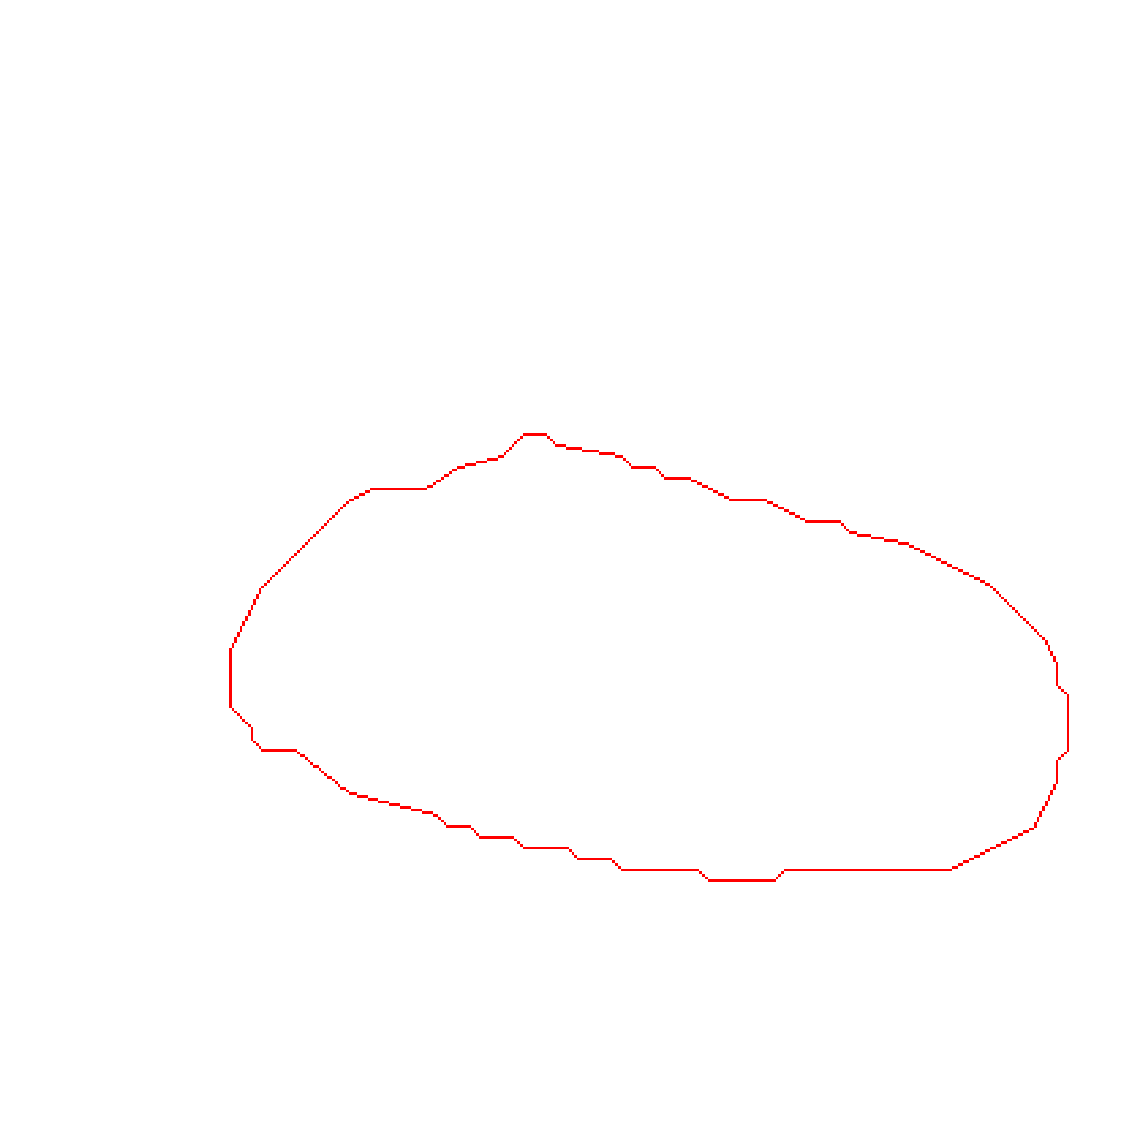

In [42]:
#Sem interpolar

im_pintada = pinta_poligonos(im_4x,poligonos_4x,1)
imshow(im_pintada, True)

In [43]:
x,y = poligonos_4x.T
x = x[0]
y = y[0]

tck, u = splprep([x, y], s=0, per=1)
u_new = np.linspace(u.min(), u.max(), 10000)
interpolado = np.array(np.around(splev(u_new, tck))).T.astype(int)

/usr/lib/python3.7/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][51]=x[1][0]
  (i, m, i)))


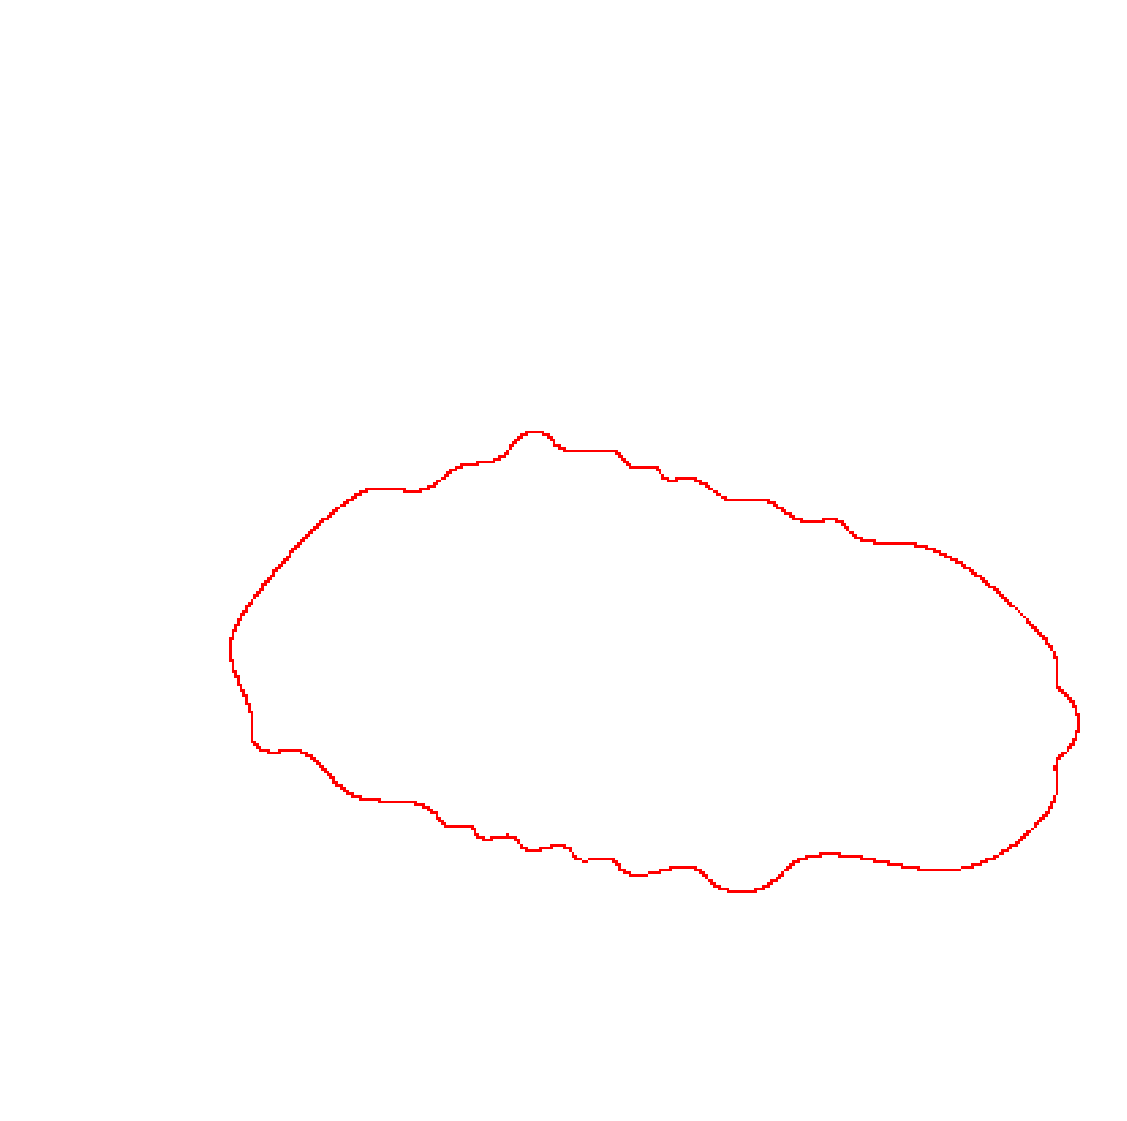

In [44]:
im_pintada = pinta_poligonos(im_4x,interpolado,1)
imshow(im_pintada, True)

In [35]:
splev(u_new, tck)

[array([72.        , 72.00591686, 72.01184382, ..., 71.98819668,
        71.99409327, 72.        ]),
 array([236.        , 235.99482073, 235.98964385, ..., 236.01036572,
        236.00518166, 236.        ])]

In [36]:
poligonos_4x

array([[[ 72, 236]],

       [[ 76, 232]],

       [[ 76, 228]],

       [[ 80, 224]],

       [[ 80, 220]],

       [[ 84, 216]],

       [[ 84, 212]],

       [[116, 180]],

       [[120, 180]],

       [[124, 176]],

       [[144, 176]],

       [[148, 172]],

       [[152, 172]],

       [[156, 168]],

       [[164, 168]],

       [[168, 164]],

       [[172, 164]],

       [[180, 156]],

       [[188, 156]],

       [[192, 160]],

       [[200, 160]],

       [[204, 164]],

       [[216, 164]],

       [[220, 168]],

       [[228, 168]],

       [[232, 172]],

       [[240, 172]],

       [[244, 176]],

       [[252, 176]],

       [[256, 180]],

       [[268, 180]],

       [[272, 184]],

       [[280, 184]],

       [[284, 188]],

       [[296, 188]],

       [[300, 192]],

       [[308, 192]],

       [[312, 196]],

       [[320, 196]],

       [[324, 200]],

       [[328, 200]],

       [[332, 204]],

       [[336, 204]],

       [[340, 208]],

       [[344, 208]],

       [[3